In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile


from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder


from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,roc_curve


from sklearn import set_config
set_config(transform_output="pandas")

In [2]:
def read_data(zip_path,file_name):
    archive = zipfile.ZipFile(zip_path, 'r')
    file = archive.open(file_name)
    df = pd.read_csv(file)
    return df

In [3]:
df = read_data("data.zip","Base.csv")
print(f"Dataset shape: {df.shape}")
df.info()

Dataset shape: (1000000, 32)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 32 columns):
 #   Column                            Non-Null Count    Dtype  
---  ------                            --------------    -----  
 0   fraud_bool                        1000000 non-null  int64  
 1   income                            1000000 non-null  float64
 2   name_email_similarity             1000000 non-null  float64
 3   prev_address_months_count         1000000 non-null  int64  
 4   current_address_months_count      1000000 non-null  int64  
 5   customer_age                      1000000 non-null  int64  
 6   days_since_request                1000000 non-null  float64
 7   intended_balcon_amount            1000000 non-null  float64
 8   payment_type                      1000000 non-null  object 
 9   zip_count_4w                      1000000 non-null  int64  
 10  velocity_6h                       1000000 non-null  float64
 11  velocity_

In [4]:
TARGET = "fraud_bool"
FEATURES = df.drop(columns="fraud_bool").columns
X = df[FEATURES]
y= df[TARGET]

In [5]:
from sklearn.model_selection import train_test_split

In [8]:
X_train , X_test, y_train, y_test = train_test_split(X,y,test_size=0.1,stratify=y,random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train, test_size=0.1,stratify=y_train)
print(f"Shape of X_train: {X_train.shape}")
print(f"Shape of X_val: {X_val.shape}")
print(f"Shape of X_test: {X_test.shape}")

Shape of X_train: (810000, 31)
Shape of X_val: (90000, 31)
Shape of X_test: (100000, 31)


In [10]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 810000 entries, 105619 to 271058
Data columns (total 31 columns):
 #   Column                            Non-Null Count   Dtype  
---  ------                            --------------   -----  
 0   income                            810000 non-null  float64
 1   name_email_similarity             810000 non-null  float64
 2   prev_address_months_count         810000 non-null  int64  
 3   current_address_months_count      810000 non-null  int64  
 4   customer_age                      810000 non-null  int64  
 5   days_since_request                810000 non-null  float64
 6   intended_balcon_amount            810000 non-null  float64
 7   payment_type                      810000 non-null  object 
 8   zip_count_4w                      810000 non-null  int64  
 9   velocity_6h                       810000 non-null  float64
 10  velocity_24h                      810000 non-null  float64
 11  velocity_4w                       810000 non-null  f

/var/folders/pt/05rkgkw9333cbp0f3wdxplcc0000gn/T/ipykernel_12682/802473059.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15)


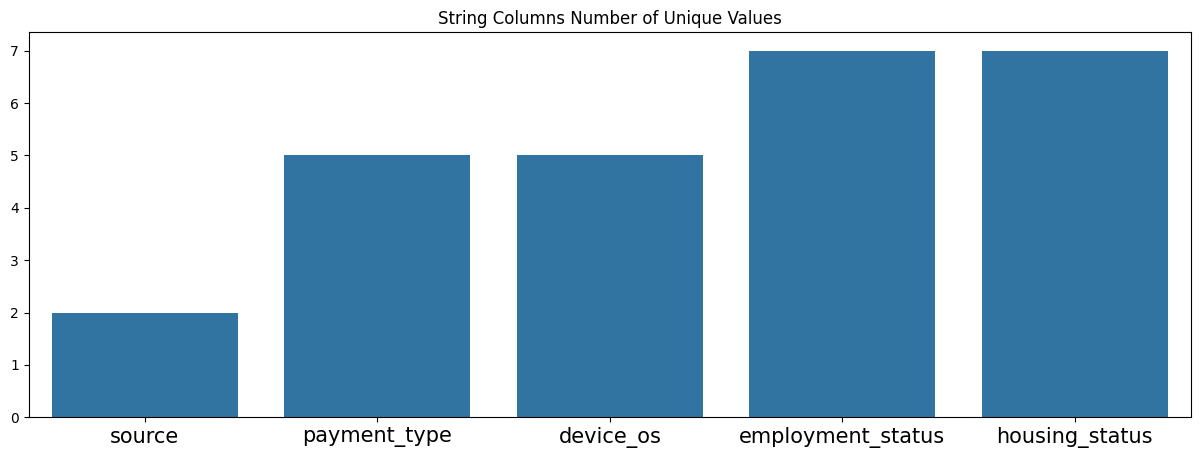

In [11]:
obj_cols = X_train.select_dtypes("object").columns
plt.figure(figsize=(15,5))
plt.title("String Columns Number of Unique Values")
g = sns.barplot(X_train[obj_cols].nunique().sort_values(ascending=True).head(10))
g.set_xticklabels(g.get_xmajorticklabels(), fontsize = 15)
plt.savefig("figures/StringUniquePlot.png")
plt.show()


In [12]:
categorical_cols = X_train.select_dtypes("object").columns

In [13]:
X_train[categorical_cols].nunique()

payment_type         5
employment_status    7
housing_status       7
source               2
device_os            5
dtype: int64

In [14]:
train_df = df.loc[X_train.index]

<Axes: xlabel='payment_type', ylabel='count'>

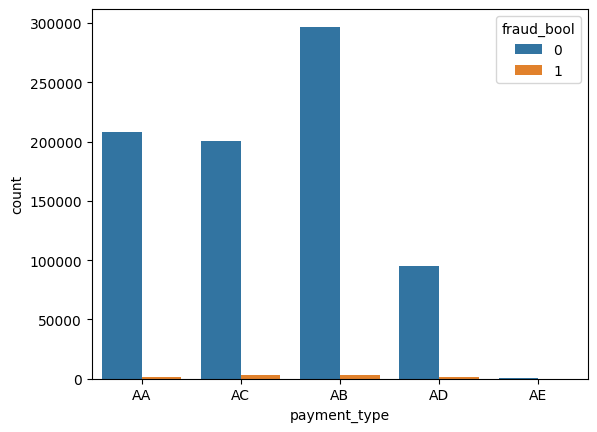

In [15]:
sns.countplot(data=train_df,x=categorical_cols[0],hue="fraud_bool")

We can safely change some variable names to 'other'.

In [16]:
def reduce_categories(df,col_list,cat_list):
    data = df.copy()
    for i in range(len(col_list)):
        data[col_list[i]] = data[col_list[i]].apply(lambda x:"other" if x not in cat_list[i] else x)

    return data

In [17]:
low_unique_value_columns = []
binary_cols = []

for col in X_train.columns:
    unique_count = X_train[col].nunique()
    if unique_count < 50:
        low_unique_value_columns.append(col)
    
    if unique_count == 2:
        binary_cols.append(col)

In [18]:
num_cols = list(X_train.select_dtypes(include=np.number).columns)

In [19]:
num_cols = [x for x in num_cols if x not in low_unique_value_columns]

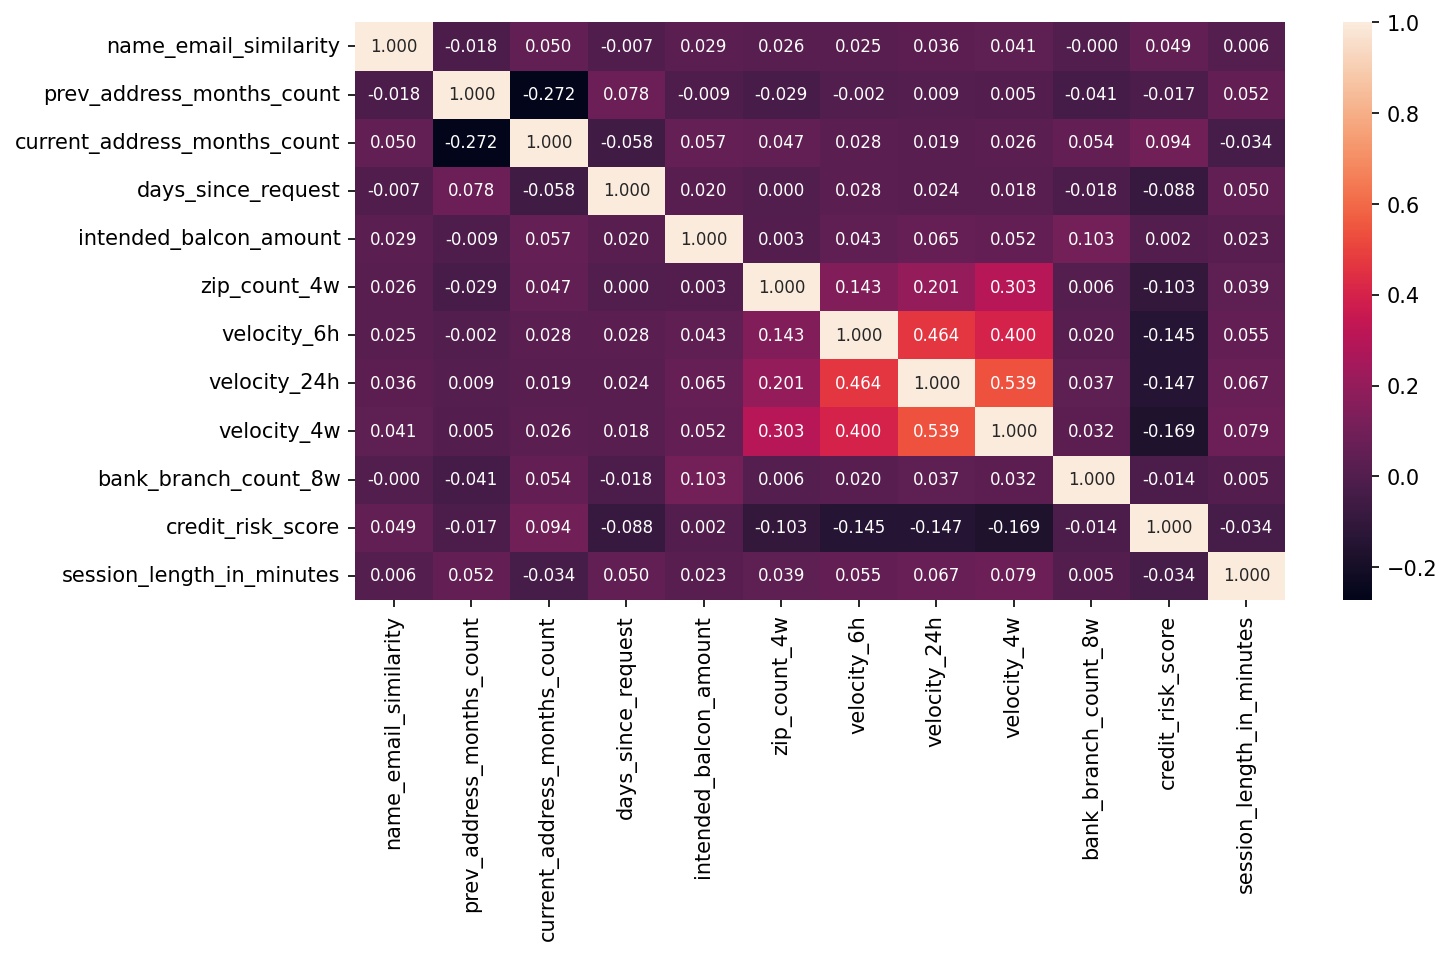

In [20]:
plt.figure(figsize=(10,5),dpi=150)
sns.heatmap(X_train[num_cols].corr(),annot=True,fmt=".3f",annot_kws={"size":8})
plt.savefig("figures/correlation_matrix.png")

In [21]:
def preprocess(df):

    '''
    df: Unprocessed dataframe
    ct: Columntransformer object
    fit_transform: If true, return fit_transform. If false, return transform
    
    
    '''
    cat_col_list = ["device_os","housing_status","employment_status","payment_type"]
 

    cat_list_to_reduce = [["windows"],
                        ["BA"],
                        ["CA"],
                        ["AC","AB"]]
    df = df.drop(columns="device_fraud_count")
    transformed_df = reduce_categories(df,cat_col_list,cat_list_to_reduce)

    return transformed_df
    

    

In [22]:
transformed_X_train = preprocess(X_train)
transformed_X_val = preprocess(X_val)
transformed_X_test = preprocess(X_test)

In [23]:
num_cols = transformed_X_train.select_dtypes(include=np.number).columns
cat_cols = transformed_X_train.select_dtypes("object").columns
ct = ColumnTransformer(
    transformers=[
        ("num",StandardScaler(),num_cols),
        ("cat",OneHotEncoder(sparse_output=False,drop="first"),cat_cols)
    ]
)

In [24]:
transformed_X_train = ct.fit_transform(transformed_X_train)
transformed_X_val = ct.transform(transformed_X_val)

In [25]:
from imblearn.under_sampling import RandomUnderSampler

In [26]:
rus = RandomUnderSampler(random_state=42)

X_undersmapled, y_undersampled = rus.fit_resample(transformed_X_train,y_train)


In [27]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from catboost import CatBoostClassifier

In [30]:
from sklearn.model_selection import StratifiedKFold

models = {"RandomForest": RandomForestClassifier(random_state=42),
          "XGBoostClassifier": xgb.XGBClassifier(),
          "CatBoostClassifier": CatBoostClassifier(random_state=42,silent=True)}

cv_idx = StratifiedKFold(n_splits= 3,random_state=42)

scores = {}

params = {"XGBoostClassifier": {
            'min_child_weight': [1, 5, 10],
            'gamma': [0.5, 1, 1.5, 2, 5],
            'subsample': [0.6, 0.8, 1.0],
            'colsample_bytree': [0.6, 0.8, 1.0],
            'max_depth': [3, 4, 5]
            },
            
        }



Decision Tree f1 score: 0.04861776500230669
RandomForest f1 score: 0.08427995602784902
XGBoostClassifier f1 score: 0.0831664869859849
CatBoostClassifier f1 score: 0.0909090909090909


Catboost is the best model.

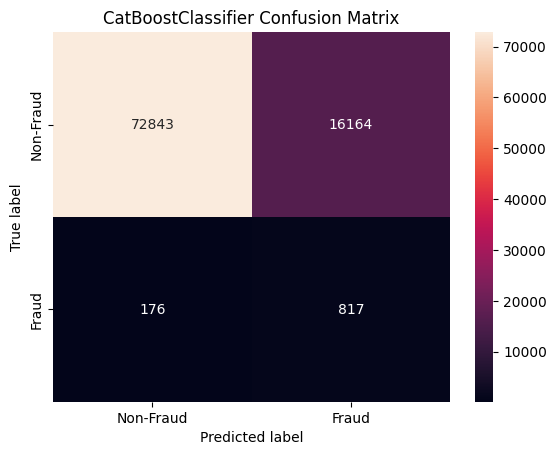

In [31]:
cm = confusion_matrix(y_val,models["CatBoostClassifier"].predict(transformed_X_val))
labels = ["Non-Fraud","Fraud"]

plt.title("CatBoostClassifier Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d',xticklabels=labels,yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [32]:
scores["CatBoostClassifier"]

0.0909090909090909

In [35]:
preds_prob = models["CatBoostClassifier"].predict_proba(transformed_X_val)

In [36]:
preds_prob=preds_prob[:,1]

In [40]:
from sklearn.metrics import classification_report

print(
    classification_report(
    y_val, preds, target_names=["Non-Fraud", "Fraud"]
    )
)

              precision    recall  f1-score   support

   Non-Fraud       1.00      0.82      0.90     89007
       Fraud       0.05      0.82      0.09       993

    accuracy                           0.82     90000
   macro avg       0.52      0.82      0.50     90000
weighted avg       0.99      0.82      0.89     90000



In [41]:
fpr, tpr, thresholds = roc_curve(y_true = y_val,
                                 y_score = models["CatBoostClassifier"].predict_proba(transformed_X_val)[:, 1], 
                                 pos_label=1)


In [42]:
pd.DataFrame({"thresholds":thresholds,
              "FPR":fpr,
              "TPR":tpr})

,thresholds,FPR,TPR
0,inf,0.000000,0.000000
1,0.999512,0.000000,0.001007
2,0.997622,0.000000,0.007049
3,0.997561,0.000011,0.007049
4,0.997465,0.000011,0.008056
...,...,...,...
1739,0.022438,0.921265,0.997986
1740,0.022437,0.921265,0.998993
1741,0.020279,0.931241,0.998993
1742,0.020279,0.931241,1.000000


In [43]:
optimal_idx = np.argmax(tpr - fpr)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


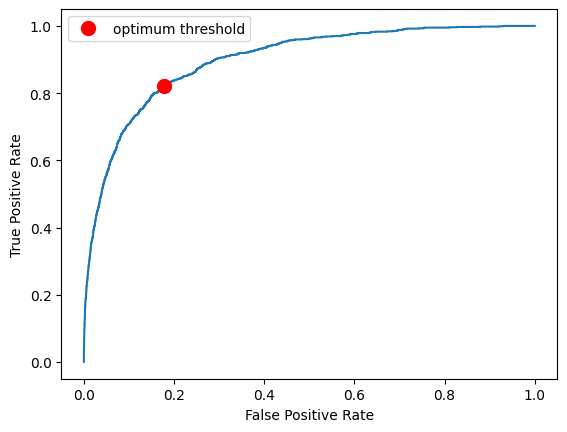

In [44]:
from sklearn.metrics import RocCurveDisplay
display = RocCurveDisplay(fpr=fpr, tpr=tpr) 
display.plot()
plt.plot(fpr[optimal_idx],tpr[optimal_idx], "or",  markersize=10, label="optimum threshold")
plt.legend(loc="best")
plt.show()

In [45]:
thresholds[optimal_idx]

0.5071796784339608

In [46]:
preds = (models["CatBoostClassifier"].predict_proba(transformed_X_val)[:, 1] > thresholds[optimal_idx]).astype(int)

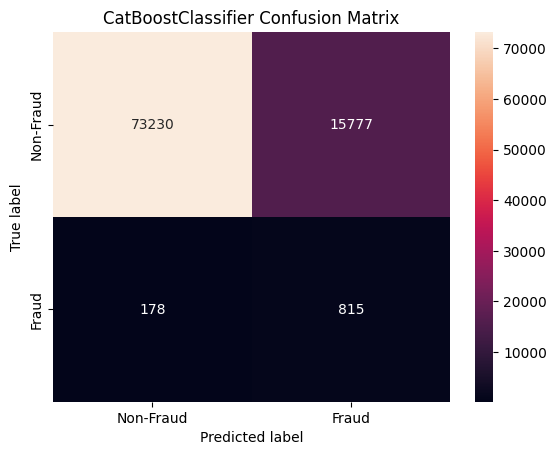

In [47]:
cm = confusion_matrix(y_val,preds)
labels = ["Non-Fraud","Fraud"]

plt.title("CatBoostClassifier Confusion Matrix")
sns.heatmap(cm, annot=True, fmt='d',xticklabels=labels,yticklabels=labels)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()